In [272]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as spimg
from scipy import optimize as spopt #I'm not familiar with cvxpy so I used scipy insted.
from PIL import Image #I prefer Pillow to imageio


For the compressed sensing, I am minimising,
$\mathcal{F} (A)$,
while meeting the condition,
\begin{equation}
    C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (A) - B = 0,
\end{equation}
where $A$ is the signal that needs to be solved for, $B$ is the sparce signal and $C$ is cropping transformation matrix such that,
\begin{equation}
    C \times A = B.
\end{equation}
$\mathcal{F}( )$ and $I$ are the FFT function and identerty matrix respectively.

In [273]:
iteration_count = 0

def L1_fit(x, y):
    return np.sum(np.abs(y -x))

def FFT_L1_fit(A_FFT, F_prime, B): #FFT of signal, measurement matrix, compressed signal
    A_FFT = np.split(A_FFT, 2) #Scipy has poor support for complex numbers.
    A_FFT = A_FFT[0] + 1j* A_FFT[1]

    B_model = np.matmul(F_prime, A_FFT)
    return L1_fit(B, B_model)

def callback_function(x):
    global iteration_count
    iteration_count += 1
    print(iteration_count, end= " ")

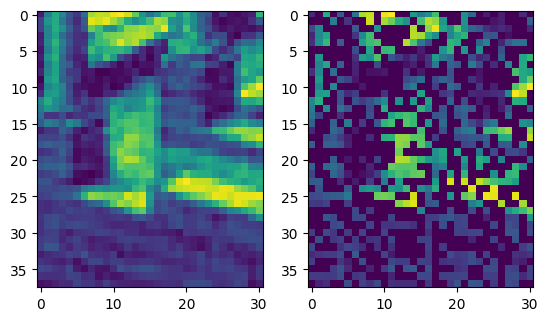

In [319]:
compression = 0.012 #fraction of the image to keep (The image is too large to process quickly)

# original image
img = Image.open('erscher_waterfall.jpg') # read image
img = np.array(img).mean(axis=2) # make image grayscale
A = img[round((1-compression**0.5)/2*img.shape[0]): #very messy way to crop the image
          round((compression**0.5-1)/2*img.shape[0]) + img.shape[0],
          round((1-compression**0.5)/2*img.shape[1]):
          round((compression**0.5-1)/2*img.shape[1]) + img.shape[1],]
#A = spimg.zoom(img, 0.1) # scipy ndimage.zoom compresses (or interpolates) an image.
total_points = np.multiply(*A.shape)
A_flat = A.flatten()

# image subsample
subsample = 0.5 #fraction of the image to subsample
random_points = np.random.choice(total_points, round(total_points *subsample), replace= False)
random_points = np.sort(random_points) #Not nessisary but makes it easier to look at.
B_flat = np.zeros(total_points)
B_flat[random_points] = A_flat[random_points]
B_sparce = A_flat[random_points]
B = np.reshape(B_flat, A.shape)

fig, axs = plt.subplots(1,2)

axs[0].imshow(A, interpolation= "nearest")
axs[1].imshow(B, interpolation= "nearest")

plt.show()

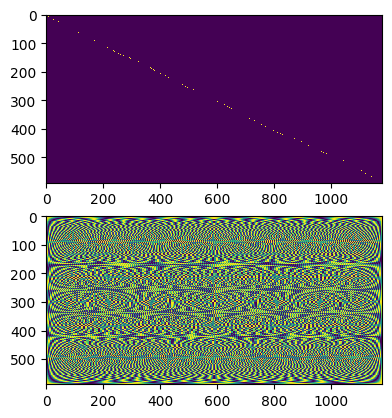

In [320]:
C = np.identity(total_points)
C = C[random_points] #cropping matrix operator

F = np.fft.ifft(np.identity(total_points), axis= 0)
F_prime = np.matmul(C, F) #THIS IS THE 'MEASUREMENT MATRIX'. Oftern denoted as A.

fig, axs = plt.subplots(2,1)

axs[0].imshow(C, interpolation= "nearest")
axs[1].imshow(np.real(F_prime), interpolation= "nearest")

plt.show()

In [321]:
null_vector = np.zeros(2*total_points, dtype= np.float16) #Scipy has poor support for complex numbers. Pretend that they are all real.

F_prime = F_prime.astype(np.complex64)
B_sparce = B_sparce.astype(np.float16)

In [322]:
########WARNING VERY SLOW!!! (15min)############

iteration_count = 0

opt_result = spopt.minimize(np.linalg.norm, #minimise the norm of the solution
                            x0= B_flat, #initial guess
                            args= (1), #L1 norm
                            callback= callback_function, #count the number of iterations
                            options= {"maxiter": 100}, #max number of iterations. (between 100 and 1000 provides decent convergence)
                            constraints={'type': 'eq', 'fun': FFT_L1_fit, "args":(F_prime, B_sparce)}) #This equation MUST be satisfied. Norm minimisation is secondary!
A_FFT_result = opt_result.x
A_FFT_result = np.split(A_FFT_result, 2)
A_FFT_result = A_FFT_result[0] + 1j *A_FFT_result[1] #Stop pretending that the complex numbers are real.
print(opt_result)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100  message: Iteration limit reached
 success: False
  status: 9
     fun: 1966397.23036551
       x: [ 7.785e+04 -7.326e+03 ...  1.105e+04  2.756e+03]
     nit: 100
     jac: [ 1.000e+00 -1.000e+00 ...  1.000e+00  1.000e+00]
    nfev: 235807
    njev: 100


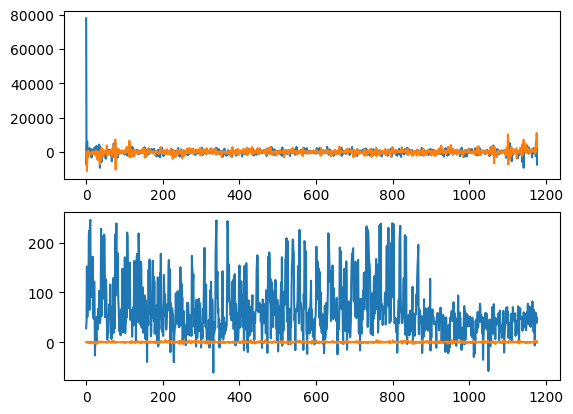

In [323]:
A_flat_result = np.fft.ifft(A_FFT_result)

fig, axs = plt.subplots(2,1)

axs[0].plot(np.real(A_FFT_result))
axs[0].plot(np.imag(A_FFT_result))
axs[1].plot(np.real(A_flat_result))
axs[1].plot(np.imag(A_flat_result))

plt.show()

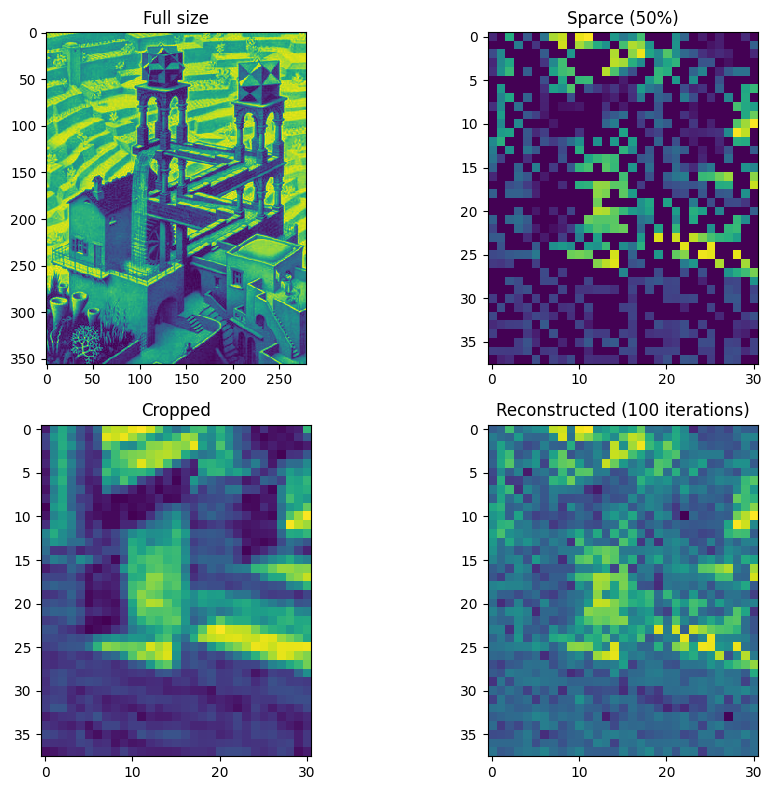

In [325]:
A_result = np.reshape(A_flat_result, A.shape)
A_result = np.real(A_result)

fig, axs = plt.subplots(2,2, figsize= (10,8))
axs[0][0].imshow(img, interpolation = "nearest")
axs[0][0].set_title("Full size")
axs[1][0].imshow(A, interpolation = "nearest")
axs[1][0].set_title("Cropped")
axs[0][1].imshow(B, interpolation = "nearest")
axs[0][1].set_title("Sparce (50%)")
axs[1][1].imshow(A_result, interpolation = "nearest")
axs[1][1].set_title("Reconstructed (100 iterations)")

plt.tight_layout()
plt.show()